Paper link: http://snap.stanford.edu/class/cs224w-2017/projects/cs224w-11-final.pdf

In [1]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import networkx as nx

In [3]:
import os

from utils.geodataframe import get_geodataframe


geojson_file_path = os.path.join('data', 'johannesburg_gpzones.json')

gdf = get_geodataframe(geojson_file_path)

gdf.head()

,geometry,MOVEMENT_ID,DISPLAY_NAME
0,"MULTIPOLYGON (((28.09045 -25.84904, 28.09514 -...",1,"0 Von Willich Avenue, Monavoni AH, Centurion"
1,"MULTIPOLYGON (((28.16310 -25.86225, 28.17109 -...",2,"0 Marconi Nook, Hennopspark, Centurion"
2,"MULTIPOLYGON (((28.19505 -25.67671, 28.20431 -...",3,"0 Apiesdoring Avenue, Wonderboom, Pretoria"
3,"MULTIPOLYGON (((28.07970 -25.53678, 28.07950 -...",4,"M17, Soshanguve South, Soshanguve"
4,"MULTIPOLYGON (((28.64247 -25.58988, 28.69198 -...",5,"R875, KwaMhlanga"


In [4]:
from utils.geodataframe import set_geodataframe_centroids

set_geodataframe_centroids(gdf)

In [5]:
gdf.head()

,geometry,MOVEMENT_ID,DISPLAY_NAME,centroid
0,"MULTIPOLYGON (((28.09045 -25.84904, 28.09514 -...",1,"0 Von Willich Avenue, Monavoni AH, Centurion",POINT (28.09407 -25.87024)
1,"MULTIPOLYGON (((28.16310 -25.86225, 28.17109 -...",2,"0 Marconi Nook, Hennopspark, Centurion",POINT (28.16644 -25.87074)
2,"MULTIPOLYGON (((28.19505 -25.67671, 28.20431 -...",3,"0 Apiesdoring Avenue, Wonderboom, Pretoria",POINT (28.20924 -25.68537)
3,"MULTIPOLYGON (((28.07970 -25.53678, 28.07950 -...",4,"M17, Soshanguve South, Soshanguve",POINT (28.06595 -25.55633)
4,"MULTIPOLYGON (((28.64247 -25.58988, 28.69198 -...",5,"R875, KwaMhlanga",POINT (28.70575 -25.60698)


In [6]:
from utils.spatial_network import get_spatial_network
spatial_network = get_spatial_network(gdf)

In [7]:
type(spatial_network)

networkx.classes.graph.Graph

In [8]:
spatial_network.nodes()

NodeView(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157',

In [9]:
nx.is_directed(spatial_network)

False

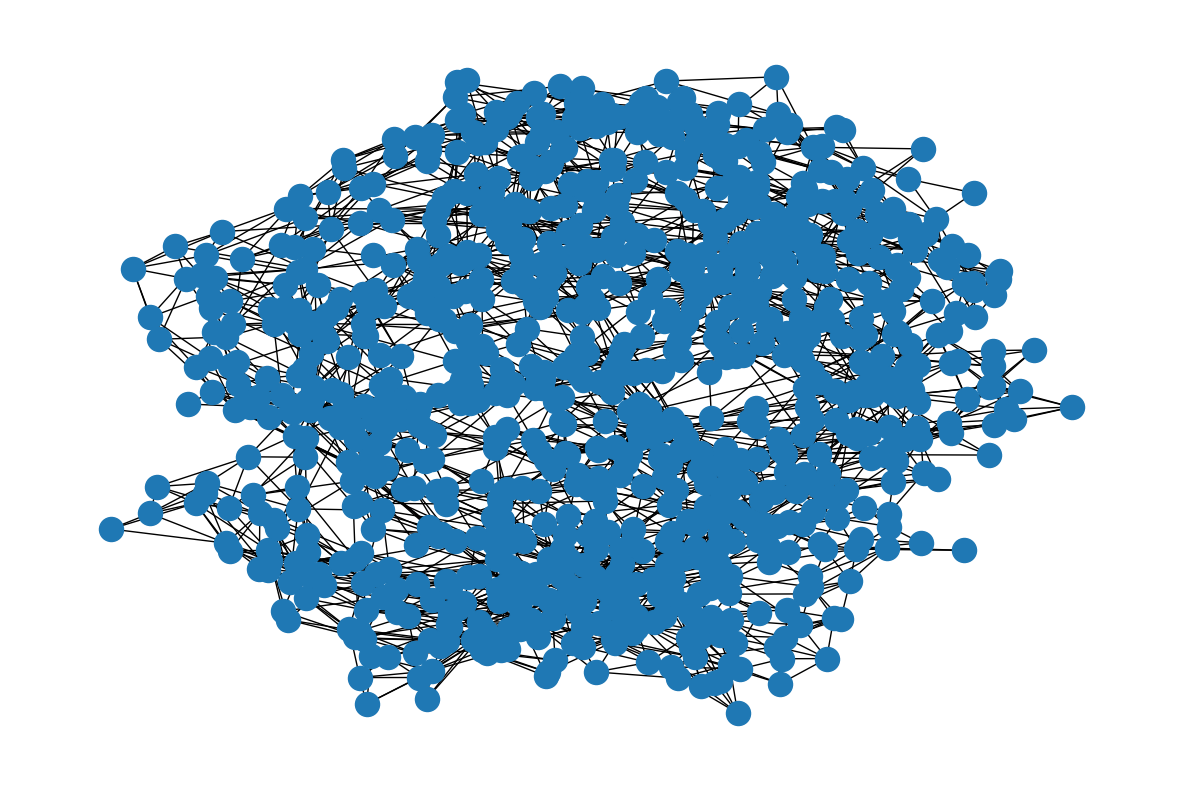

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

nx.draw(spatial_network)
plt.show()

In [11]:
import matplotlib.pyplot as plt

In [12]:
type(plt.cm.coolwarm)

matplotlib.colors.LinearSegmentedColormap

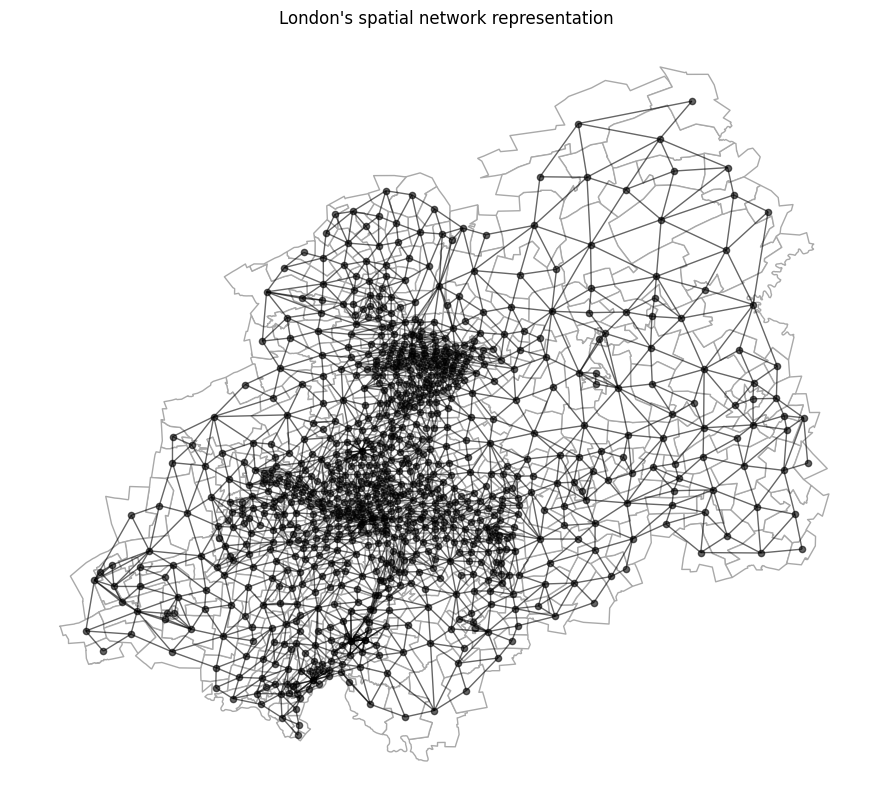

In [13]:
from utils.geodataframe import get_geodataframe_coordinates_dict

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

gdf.plot(ax=ax, edgecolor='darkgray', color='white')

coordinates = get_geodataframe_coordinates_dict(gdf)

nx.draw(
    spatial_network,
    coordinates,
    ax=ax,
    node_size=20,
    width=1,
    node_color="black",
    edge_color="black",
    alpha=.6,
)

plt.title("London's spatial network representation")

plt.show()

In [14]:
import networkx as nx
import pandas as pd

csv_path = os.path.join('data', 'johannesburg-gpzones-2017-3-OnlyWeekdays-HourlyAggregate.csv')

df = pd.read_csv(csv_path)
df.drop(['standard_deviation_travel_time', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'],
        inplace=True, axis=1)
df.head()

,sourceid,dstid,hod,mean_travel_time
0,1,2,3,666.36
1,1,2,7,998.54
2,1,2,11,432.03
3,1,2,15,465.53
4,1,2,19,513.78


In [15]:
df['sourceid'] = df['sourceid'].apply(str)
df['dstid'] = df['dstid'].apply(str)

In [16]:
#df_9 = df[df['hod'] == 5]

In [17]:
#df_9.head()

In [18]:
#G = nx.from_pandas_edgelist(df_9, source='sourceid', target='dstid', edge_attr='mean_travel_time')

In [19]:
temporal_networks_dict = {
    h: nx.from_pandas_edgelist(df[df['hod'] == h], 
                            source='sourceid', 
                            target='dstid', 
                            edge_attr='mean_travel_time', 
                            create_using=nx.DiGraph())
    for h in range(24)
}

In [20]:
len(temporal_networks_dict)

24

In [21]:
type(temporal_networks_dict[0])

networkx.classes.digraph.DiGraph

In [22]:
nx.is_directed(temporal_networks_dict[0])

True

In [23]:
'''from utils.geodataframe import get_geodataframe_coordinates_dict

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

gdf.plot(ax=ax, edgecolor='darkgray', color='white')

coordinates = get_geodataframe_coordinates_dict(gdf)

print(type(list(coordinates.keys())[0]))

nx.draw(
    temporal_network,
    coordinates,
    ax=ax,
    node_size=20,
    width=1,
    node_color="black",
    edge_color="black",
    alpha=.6,
)

plt.title("London's spatial network representation")

plt.show()''';

In [24]:
#set(nx.k_components(temporal_network))

# Metric Node degree

### out-deg Temporal

In [25]:
temporal_network_9 = temporal_networks_dict[9]

In [26]:
from utils.metrics import get_metric

temporal_network_9_in_deg = get_metric(temporal_network_9, 'in-deg', weight='mean_travel_time')

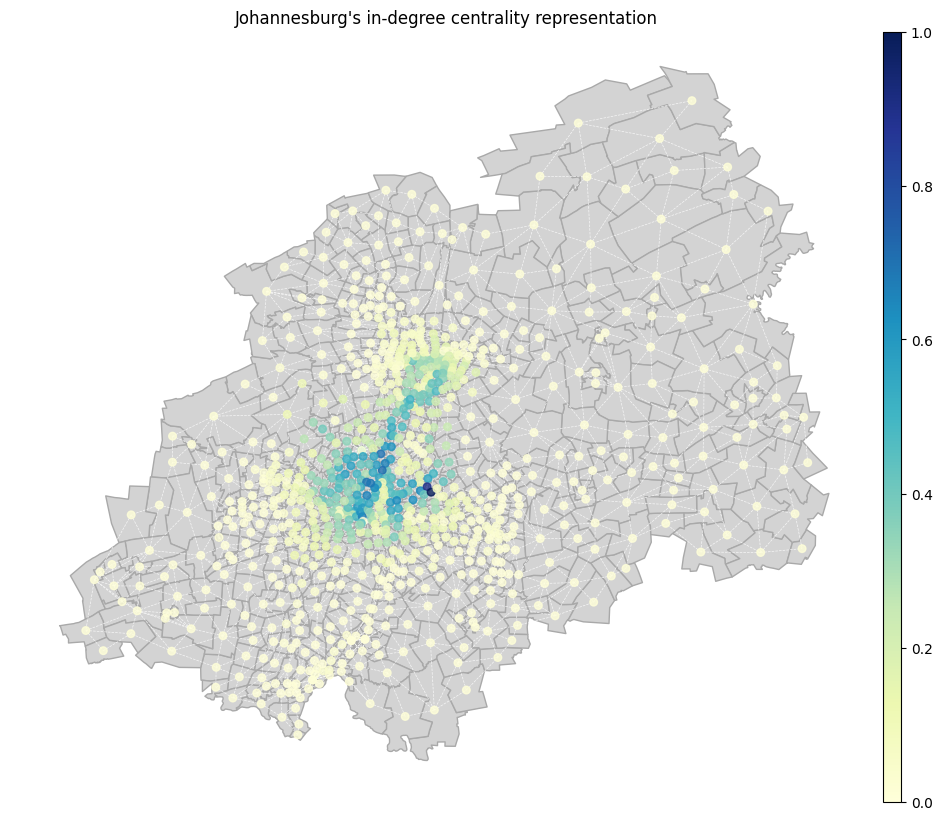

In [27]:
from utils.graphics import plot_metric

plot_metric(gdf, spatial_network, temporal_network_9_in_deg, title = "Johannesburg's in-degree centrality representation")

In [28]:
from utils.metrics import get_metric

temporal_network_9_out_deg = get_metric(temporal_network_9, 'out-deg', weight='mean_travel_time')

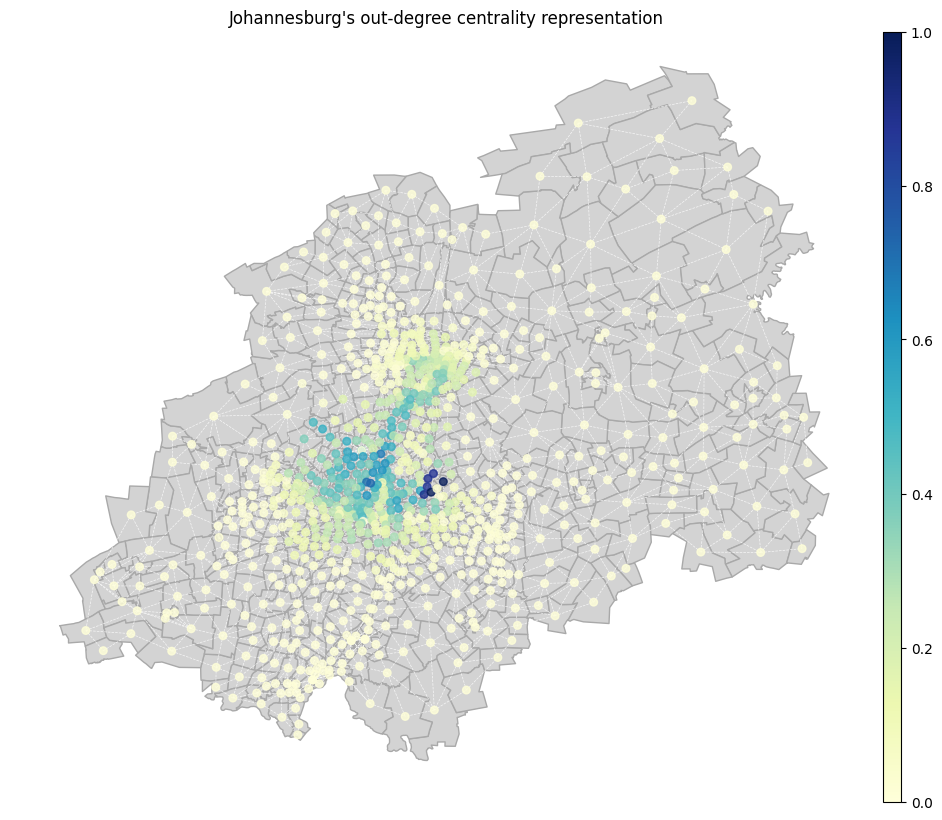

In [29]:
plot_metric(gdf, spatial_network, temporal_network_9_out_deg, title = "Johannesburg's out-degree centrality representation")